## Описание проекта

Компания такси собрала исторические данные о заказах такси в аэропортах.  
Необходимо спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных
* datetime - временные данные разбиты на отрезки по десять минут;
* num_orders - количество заказов.

# 1. Подготовка

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose


pd.set_option('display.max_columns', 100)

***
### Первичное изучение данных

Загрузим данные и посмотрим на них.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


***
**Вывод**

В наборе данных 26496 наблюдений и 2 признака - datetime и num_orders.

**Признаки**
* datetime — отсечка временного периода, состоит из даты и времени, шаг - 10 минут;  
* num_orders — количество заказов; 

***
## Предобработка данных

Изменим тип данных Datetime с object на datetime64

In [4]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

Установим индекс таблицы равным столбцу datetime

In [5]:
taxi = taxi.set_index('datetime')

Отсортируем выборку по возрастанию даты

In [6]:
taxi.sort_index(inplace=True)

Проверим наличие пропусков

In [7]:
taxi.isnull().sum()

num_orders    0
dtype: int64

Проведем ресмплирование данных по одному часу

In [8]:
taxi = taxi.resample('1H').sum()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Проверим, в хронологическом ли порядке расположены даты наблюдений

In [9]:
taxi.index.is_monotonic

True

Данные ресемплированы, расположены в хронологическом порядке, пропуски отсутствуют.

***
## Вывод

На данном этапе были проведены первичное изучение данных и их предобработка.  
Были выполнены следующие шаги:
* Изменение типа данных столбца datetime;
* Установка индекса таблицы равным столбцу datetime
* Проверили, что в выборке нет пропусков;
* Проверили, что данные расположены в хронологическом порядке;
* Провели ресемплинг данных по одному часу.

# 2. Анализ

Перед тем, как будем обучать модели прогнозирования попробуем более глубоко изучить данные и проанализировать их.

Построим график временного ряда и первично оценим динамику изменений количества заказов такси.

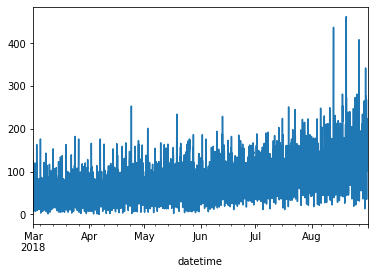

In [10]:
taxi['num_orders'].plot()

На получившемся графике ничего не видно.  
Проведем ресемплинг, сгруппируем данные по дням и найдем скользящее среднее, чтобы оценить общую динамику изменений количества заказов.

In [11]:
taxi_new = taxi.copy()
taxi_new = taxi_new.resample('1D').sum()
taxi_new['rolling_mean'] = taxi_new['num_orders'].rolling(5).mean()
taxi_new = taxi_new.dropna()

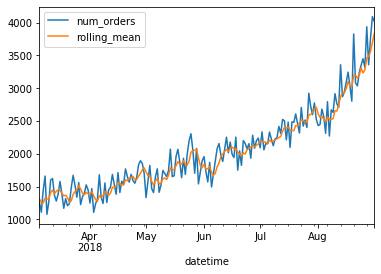

In [12]:
taxi_new[['num_orders', 'rolling_mean']].plot()

График стал более читабелен и из него можно сделать вывод, что присутсвует тренд на увеличение количества заказов такси от месяца к месяцу.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
да, согласен

</b></font>

Проведем декомпозицию временного ряда, сгруппированного по дням на тренд и сезонную составляющую.

In [13]:
decomposed = seasonal_decompose(taxi_new)

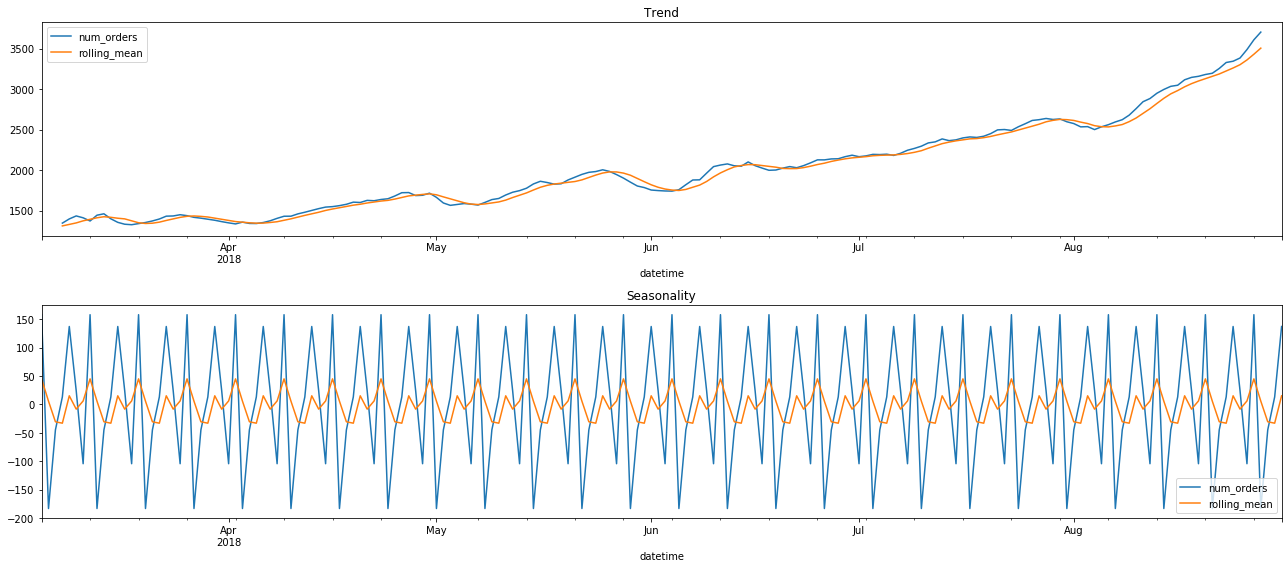

In [14]:
plt.figure(figsize=(18, 8))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Линия тренда стала более гладкой и с явным направлением вверх.  

График сезонной составляющей недостаточно читабелен, чтобы сделать конкретные выводы.  
Для этого построим график количества заказов такси по дням двух недель с 9 по 22 апреля.

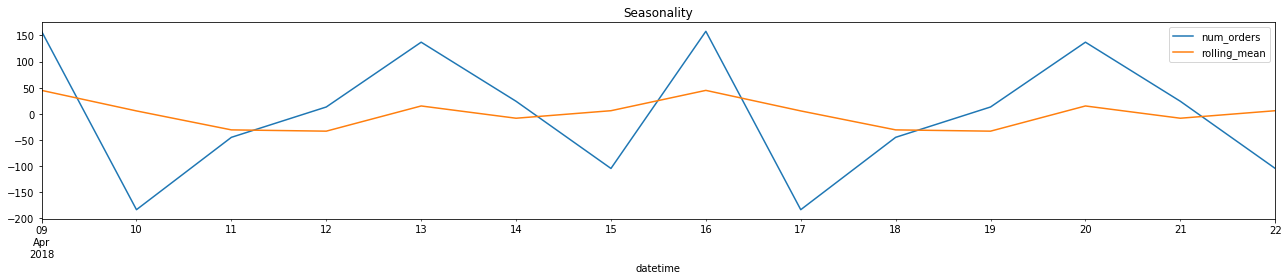

In [15]:
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-04-09':'2018-04-22'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Из получившегося графика можно сделать следующие наблюдения:
* Наиболее часто такси заказывают по понедельникам и пятницам, что объясняется большим количеством полетов на выходные;
* Наименее часто во вторник и в воскресенье;
* Начиная со вторника и до пятницы идет планомерный рост количества заказов, с последующим снижением в субботу и воскресенье.

Теперь изучим сезонную составляющую в почасовом графике заказов за два дня - с 12 по 14 апреля, т.е. в четверг и пятницу.

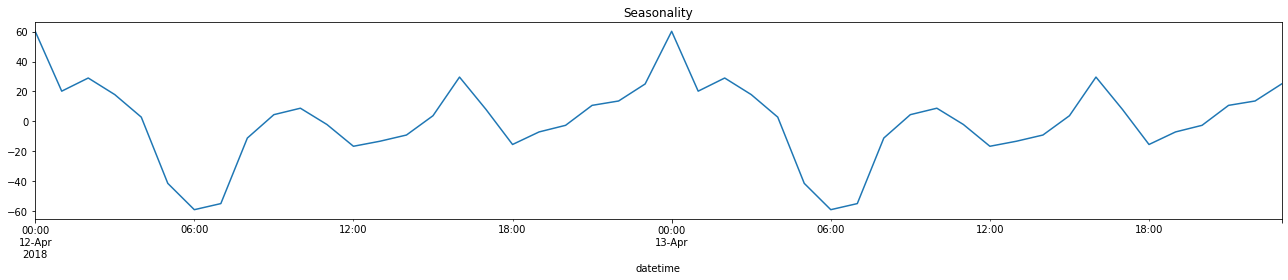

In [16]:
decomposed1 = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize=(18, 4))
decomposed1.seasonal['2018-04-12':'2018-04-13'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Из графика видно, что наиболее часто такси в аэропортах чаще заказывают в полночь.  
Это объясняется тем, что аэроэкспрессы в это время уже не работают и людям приходиться заказывать такси, чтобы добраться до дома.  
В 6 утра минимальное количество заказов, что объясняется небольшим количеством ночных рейсов.  
В течение дня количество заказов меняется, но без значительных пиков.

***
## Вывод

На данном этапе мы проанализировали направление тренда и сезонность временного ряда и сделали следующие выводы:
* Есть общий тренда на увеличение количества заказов такси от месяца к месяцу;
* Наиболее часто такси заказывают по понедельникам и пятницам, что объясняется большим количеством полетов на выходные;
* Чаще всего такси заказывают около полуночи и причиной этого является то, что аэроэкспрессы в это время уже не работают и людям приходиться заказывать такси, чтобы добраться до дома.

# 3. Обучение

На этом этапе выполним следующие шаги:
* Создадим признаки для обучения моделей;
* Обучим модели и выберем наиболее перспективные по результатм на валидационной выборке;
* Подберем гиперпараметры для нескольких лучших моделей и выберем наилучшую модель.

***
### Создание признаков

Создадим признаки для горизонта прогнозирования в один шаг.  

Напишем функцию для создания признаков:
* Календарные признаки - месяц, день, день недели, час;
* «Отстающие значения»;
* Скользящее среднее.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

Запустим нашу функуцию со сдвигом в 10 шагов.

In [18]:
make_features(taxi, 10, 10)
taxi

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,173.3
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,166.6
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,162.9


***
### Разделение выборки на обучающую и целевую

Выделим целевой признак price в отдельную таблицу

In [19]:
taxi_features = taxi.drop(['num_orders'], axis=1)
taxi_target = taxi['num_orders']

Разделим данные на 3 выборки - обучающую, валидационную и тестовую в соотношении 80/10/10.

In [20]:
taxi_frest, taxi_ftest, taxi_trest, taxi_ttest = train_test_split(
    taxi_features, taxi_target, test_size=0.1, shuffle=False, random_state=12345)
taxi_ftrain, taxi_fvalid, taxi_ttrain, taxi_tvalid = train_test_split(
    taxi_frest, taxi_trest, test_size=0.11, shuffle=False, random_state=12345)

In [21]:
print(taxi_ftrain.shape, taxi_ftrain.index.min(), taxi_ftrain.index.max())
print(taxi_fvalid.shape, taxi_fvalid.index.min(), taxi_fvalid.index.max())
print(taxi_ftest.shape, taxi_ftest.index.min(), taxi_ftest.index.max())

(3528, 15) 2018-03-01 10:00:00 2018-07-26 09:00:00
(437, 15) 2018-07-26 10:00:00 2018-08-13 14:00:00
(441, 15) 2018-08-13 15:00:00 2018-08-31 23:00:00


Получили 3 последовательные выборки, все данные в хронологическом порядке.

***
### Обучение моделей

Создадим функцию обучения модели и проведем обучение моделей без подбора гиперпараметров.

In [22]:
def mlmodel(model, ft, tt, fv, tv):
    model = model
    model.fit(ft, tt)
    prediction_tr = model.predict(ft)
    prediction = model.predict(fv)

    print("RMSE: ", mean_squared_error(tv, prediction) ** 0.5)

**Линейная регрессия**

In [23]:
%%time
mlmodel(LinearRegression(), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  40.4305010834674
CPU times: user 13.3 ms, sys: 12.9 ms, total: 26.2 ms
Wall time: 7.56 ms


**Дерево решений**

In [24]:
%%time
mlmodel(DecisionTreeRegressor(), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  39.481218197885134
CPU times: user 78 ms, sys: 8.11 ms, total: 86.1 ms
Wall time: 144 ms


**Случайный лес**

In [25]:
%%time
mlmodel(RandomForestRegressor(), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  31.830195211954347
CPU times: user 321 ms, sys: 3.38 ms, total: 325 ms
Wall time: 343 ms


**Метод ближайших соседей**

In [26]:
%%time
mlmodel(KNeighborsRegressor(), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  38.696772256434535
CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 286 ms


**GradientBoostingRegressor**

In [27]:
%%time
mlmodel(GradientBoostingRegressor(), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  32.58218171136286
CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 310 ms


**LGBMRegressor**

In [28]:
%%time
mlmodel(LGBMRegressor(verbose = 0), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  31.923859783681397
CPU times: user 1.23 s, sys: 17.3 ms, total: 1.25 s
Wall time: 1.2 s


**CatBoostRegressor**

In [29]:
%%time
mlmodel(CatBoostRegressor(verbose = 0), taxi_ftrain, taxi_ttrain, taxi_fvalid, taxi_tvalid)

RMSE:  32.20678801594108
CPU times: user 17.8 s, sys: 3.4 s, total: 21.2 s
Wall time: 24.6 s


In [30]:
d = {'Model' : ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 
                'GradientBoostingRegressor', 'LightGBM', 'CatBoost'],
    'RMSE' :pd.Series([40.60, 40.62, 32.14, 38.69, 32.62, 31.92, 32.202]),
     'time, s': pd.Series([0.015, 0.054, 0.330, 0.274, 0.313, 1.11, 23.800])
    }
df1 = pd.DataFrame(d)
df1

,Model,RMSE,"time, s"
0,LinearRegression,40.600,0.015
1,DecisionTreeRegressor,40.620,0.054
2,RandomForestRegressor,32.140,0.330
3,KNeighborsRegressor,38.690,0.274
4,GradientBoostingRegressor,32.620,0.313
5,LightGBM,31.920,1.110
6,CatBoost,32.202,23.800


На данном этапе близкие результаты показали модели RandomForestRegressor, GradientBoostingRegresso, LGBMRegressor и CatBoostRegressor.
Модели CatBoostRegressor требуется очень много времени на обучение, поэтому не будем ее рассматривать в дальнейшем.  
Подберем гиперпараметры для моделей GradientBoostingRegressor, LGBMRegressor.

***
### Подбор гиперпараметров

Подберем наилучшие гиперпараметры для модели LGBMRegressor с помощью функции GridSearchCV

In [31]:
def gridsearch_result(model, parameters, f, t, scorer):
    gridsearch = GridSearchCV(estimator=model, param_grid = parameters, refit=False, scoring=scorer, cv=2)
    gridsearch = gridsearch.fit(f, t)
    optimal_score = gridsearch.best_score_
    optimal_parameters = gridsearch.best_params_
    print('Лучшие гиперпараметры: ', optimal_parameters)
    print('Лучшее RMSE: {:.2f}'.format((-optimal_score) ** 0.5))

**Случайный лес**

In [32]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
gridsearch_result(RandomForestRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 90, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 26.50


**LightGBM**

In [33]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
gridsearch_result(LGBMRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 25.89


**GradientBoostingRegressor**

In [34]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
gridsearch_result(GradientBoostingRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 26.90


Наилучший результат RMSE показала модель LGBMRegressor и он равен 25.64.  

Лучшие гиперпараметры 'max_depth': 13, 'n_estimators': 60, 'random_state': 12345, 'verbose': 0.

# 4. Тестирование

Проведем итоговое тестирование на тестовой выборке.

In [35]:
%%time
mlmodel(RandomForestRegressor(n_estimators=90, max_depth=13, random_state=12345, verbose=0), 
        taxi_frest, taxi_trest, taxi_ftest, taxi_ttest)

RMSE:  44.36139264408909
CPU times: user 2.73 s, sys: 1.35 ms, total: 2.73 s
Wall time: 2.75 s


In [36]:
%%time
mlmodel(LGBMRegressor(n_estimators=60, max_depth=13, random_state=12345, verbose=0), 
        taxi_frest, taxi_trest, taxi_ftest, taxi_ttest)

RMSE:  43.36241606808117
CPU times: user 813 ms, sys: 8.5 ms, total: 821 ms
Wall time: 777 ms


In [37]:
%%time
mlmodel(GradientBoostingRegressor(n_estimators=60, max_depth=5, random_state=12345, verbose=0), 
        taxi_frest, taxi_trest, taxi_ftest, taxi_ttest)

RMSE:  43.88465151670791
CPU times: user 452 ms, sys: 3.69 ms, total: 456 ms
Wall time: 458 ms


Проведем проверку на адекватность с помощью метода, в котором новое значение прогнозируется предыдущим значением ряда.

In [38]:
%%time
pred_previous = taxi_ttest.shift()
pred_previous.iloc[0] = taxi_ttest.iloc[-1]
print("RMSE:", mean_squared_error(taxi_ttest, pred_previous) ** 0.5)

RMSE: 58.83232640636853
CPU times: user 1.54 ms, sys: 453 µs, total: 1.99 ms
Wall time: 1.57 ms


Полученный RMSE равен 58.93501814402337, что достаточно сильно больше, чем полученный с помощью модели результат.

In [40]:
d = {'Model' : ['RandomForestRegressor', 'LightGBM', 'GradientBoostingRegressor', 'Dummy'],
    'RMSE' :pd.Series([44.36, 42.75, 44.57, 58.93]),
     'time, s': pd.Series([2.750, 0.726, 0.464, 0.002])
    }
df1 = pd.DataFrame(d)
df1

,Model,RMSE,"time, s"
0,RandomForestRegressor,44.36,2.750
1,LightGBM,42.75,0.726
2,GradientBoostingRegressor,44.57,0.464
3,Dummy,58.93,0.002


## Вывод

Наилучший результат RMSE, равный 42.75, показала модель LGBMRegressor, однако стоит заметить, что скорость работы модели GradientBoostingRegressor почти в два раза выше, при не сильно большой разнице в значении RMSE.  

В дальнейшую работу можно взять обе модели, выбрав лучшую из них в зависимости от того, какой параметр более важен - скорость или точность.

***
# Общий Вывод

В данной работе был проведен анализ данных о заказах такси в аэропортах.  

Основными выводами являются:
* Есть общий тренда на увеличение количества заказов такси от месяца к месяцу;
* Наиболее часто такси заказывают по понедельникам и пятницам, что объясняется большим количеством полетов на выходные;
* Чаще всего такси заказывают около полуночи и причиной этого является то, что аэроэкспрессы в это время уже не работают и людям приходиться заказывать такси, чтобы добраться до дома;

* Наилучший результат RMSE, равный 42.75, показала модель LGBMRegressor, однако скорость работы модели GradientBoostingRegressor почти в два раза выше, при не сильно большой разнице в значении RMSE.

В дальнейшую работу можно взять обе модели, выбрав лучшую из них в зависимости от того, какой параметр более важен - скорость или точность